# Training

In [4]:
# Original
import numpy as np 
import pandas as pd 
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import seaborn as sns
import matplotlib.pyplot as plt
import random
import seaborn as sns
from collections import Counter

from PIL import Image
from skimage import io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim

import torchvision.datasets
import torchvision.transforms as T 
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader
# Transforming the Data ToTensor and Normalize it 
transforms = T.Compose([T.ToTensor(),T.Resize((256,256)),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

class TSignsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.class_counts = Counter()  # Counter to store class counts
        
        # Iterate over each folder (class) in the directory
        for class_id in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_id)
            
            # Make sure it's a directory
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        self.data.append({
                            'path': os.path.join(class_dir, filename),
                            'class_id': int(class_id)
                        })
                        # Increment the count for the current class_id
                        self.class_counts[int(class_id)] += 1
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]['path']
        image = Image.open(image_path)
        y_class = torch.tensor(self.data[index]['class_id'])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_class)

dataset_path = '/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/Train'
dataset_set = TSignsDataset(dataset_path,transform=transforms)

#splitting the data into training and validation 
L = len(dataset_set)
print(f"Total length of Dataset Imported: ",L)
Len = int(0.8*L)
train_set, val_set = random_split(dataset_set,[Len,int(L-Len)])

#Loading the data into DataLoader

train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=val_set, batch_size=32, shuffle=False)

dataloaders = {'training':train_loader,'validation':valid_loader}
dataset_sizes = {'training':len(train_loader.dataset),'validation':len(valid_loader.dataset)}
print(dataset_sizes)

# Store metrics
train_loss, val_loss = [], []
train_acc, val_acc = [], []

#test_ran_sqr_sin_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
def Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path):
        best_model_weights = model.state_dict()
        best_acc = 0.0
    
        for epoch in range(num_epochs):
            print("epoch {}/{}".format(epoch+1,num_epochs))
            print("*" * 10)

            for x in ["training","validation"]:
                if x == "training" :
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_accuracy = 0

                for data in dataloaders[x]:
                    img , y = data
                    img , y = img.to(device) , y.to(device)

                    optimizer.zero_grad()
                    y_pred = model(img)
                    loss = criterion(y_pred,y)
                    _, preds = torch.max(y_pred, dim=1)

                    if x == 'training':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item()
                    running_accuracy += torch.sum(preds == y.data)


                epoch_loss = running_loss / dataset_sizes[x]
                epoch_acc = running_accuracy / dataset_sizes[x]

                print('{} Loss: {:.4f} || Accuracy: {:.4f}'.format(x, epoch_loss, epoch_acc))

                # Save metrics
                if x == 'training':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                else:
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)

                # deep copy the model
                if x == 'validation' and epoch_acc > best_acc:
                    best_acc = epoch_acc


        # load best model weights
        # torch.save(model.state_dict(), out_path)
        return print('Best validation Accuracy: {:4f}'.format(best_acc))

Total length of Dataset Imported:  40031
{'training': 32024, 'validation': 8007}


In [25]:
# With clean and backdoored validation
import numpy as np 
import pandas as pd 
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import seaborn as sns
import matplotlib.pyplot as plt
import random
import seaborn as sns
from collections import Counter

from PIL import Image
from skimage import io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
import torch.optim as optim

import torchvision.datasets
import torchvision.transforms as T 
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader
# Transforming the Data ToTensor and Normalize it 
transforms = T.Compose([T.ToTensor(),T.Resize((256,256)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

class TSignsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.class_counts = Counter()  # Counter to store class counts
        
        # Iterate over each folder (class) in the directory
        for class_id in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_id)
            
            # Make sure it's a directory
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        self.data.append({
                            'path': os.path.join(class_dir, filename),
                            'class_id': int(class_id)
                        })
                        # Increment the count for the current class_id
                        self.class_counts[int(class_id)] += 1
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]['path']
        image = Image.open(image_path)
        y_class = torch.tensor(self.data[index]['class_id'])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_class)

dataset_path = '/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/Train'
clean_dataset_set = TSignsDataset(dataset_path,transform=transforms)
datas_path = '/home/cc7486/Desktop/Research/MLLsecurity/gtsrb-german-traffic-sign/Fix-gen/Train_test_1/'
bck_dataset_set = TSignsDataset(datas_path,transform=transforms)

#splitting the data into training and validation 
L1 = len(clean_dataset_set)
L2 = len(bck_dataset_set)
print(f"Total length of Dataset Imported: ",L1, L2, L1+L2)
Len1 = int(0.8*L1)
Len2 = int(0.8*L2)
train_set, val_set = random_split(clean_dataset_set,[Len1,int(L1-Len1)])
bck_train_set, bck_val_set = random_split(bck_dataset_set,[Len2,int(L2-Len2)])

# Combine Datasets
train_set = ConcatDataset([train_set, bck_train_set])
vali_set = ConcatDataset([val_set, bck_val_set])

#Loading the data into DataLoader
train_loader = DataLoader(dataset=train_set, batch_size=40, shuffle=True)
valid_loader = DataLoader(dataset=vali_set, batch_size=40, shuffle=False)
clean_val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=False)
bck_val_loader = DataLoader(dataset=bck_val_set, batch_size=1, shuffle=False)

dataloaders = {'training':train_loader,'validation':valid_loader, "clean": clean_val_loader, "backdoor": bck_val_loader}
dataset_sizes = {'training':len(train_loader.dataset),'validation':len(valid_loader.dataset), "clean": len(clean_val_loader), "backdoor": len(bck_val_loader)}
print(dataset_sizes)

# Store metrics
train_loss, val_loss, clean_loss, back_loss = [], [], [], []
train_acc, val_acc, clean_acc, back_acc = [], [], [], []

#test_ran_sqr_sin_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
def Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path):
        best_model_weights = model.state_dict()
        best_acc = 0.0
    
        for epoch in range(num_epochs):
            print("epoch {}/{}".format(epoch+1,num_epochs))
            print("*" * 10)

            for x in ["training","validation","clean","backdoor"]:
                if x == "training" :
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_accuracy = 0

                for data in dataloaders[x]:
                    img , y = data
                    img , y = img.to(device) , y.to(device)

                    optimizer.zero_grad()
                    y_pred = model(img)
                    loss = criterion(y_pred,y)
                    _, preds = torch.max(y_pred, dim=1)

                    if x == 'training':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item()
                    running_accuracy += torch.sum(preds == y.data)


                epoch_loss = running_loss / dataset_sizes[x]
                epoch_acc = running_accuracy / dataset_sizes[x]

                print('{} Loss: {:.4f} || Accuracy: {:.4f}'.format(x, epoch_loss, epoch_acc))

                # Save metrics
                if x == 'training':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                elif x == "validation":
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)
                elif x == "clean":
                    clean_loss.append(epoch_loss)
                    clean_acc.append(epoch_acc)
                else:
                    back_loss.append(epoch_loss)
                    back_acc.append(epoch_acc)

                # deep copy the model
                if x == 'validation' and epoch_acc > best_acc:
                    best_acc = epoch_acc


        # load best model weights
        torch.save(model.state_dict(), out_path)
        return print('Best validation Accuracy: {:4f}'.format(best_acc))

Total length of Dataset Imported:  39585 424 40009
{'training': 32007, 'validation': 8002, 'clean': 7917, 'backdoor': 85}


# Better Training

Test Training

In [26]:
from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
num_epochs = 100
batch_size = 40
out_path = "models/test_alexnet_ran_sqr_sin_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/100
**********


/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


training Loss: 0.0489 || Accuracy: 0.4239
validation Loss: 0.0140 || Accuracy: 0.8582
clean Loss: 0.4522 || Accuracy: 0.8674
backdoor Loss: 7.5303 || Accuracy: 0.0000
epoch 2/100
**********
training Loss: 0.0080 || Accuracy: 0.9175
validation Loss: 0.0045 || Accuracy: 0.9629
clean Loss: 0.1189 || Accuracy: 0.9728
backdoor Loss: 5.1272 || Accuracy: 0.0353
epoch 3/100
**********
training Loss: 0.0033 || Accuracy: 0.9661
validation Loss: 0.0020 || Accuracy: 0.9808
clean Loss: 0.0708 || Accuracy: 0.9822
backdoor Loss: 1.0343 || Accuracy: 0.8471
epoch 4/100
**********
training Loss: 0.0018 || Accuracy: 0.9812
validation Loss: 0.0011 || Accuracy: 0.9878
clean Loss: 0.0402 || Accuracy: 0.9885
backdoor Loss: 0.5531 || Accuracy: 0.9176
epoch 5/100
**********
training Loss: 0.0013 || Accuracy: 0.9855
validation Loss: 0.0009 || Accuracy: 0.9913
clean Loss: 0.0283 || Accuracy: 0.9922
backdoor Loss: 0.8970 || Accuracy: 0.9059
epoch 6/100
**********
training Loss: 0.0011 || Accuracy: 0.9875
validati

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

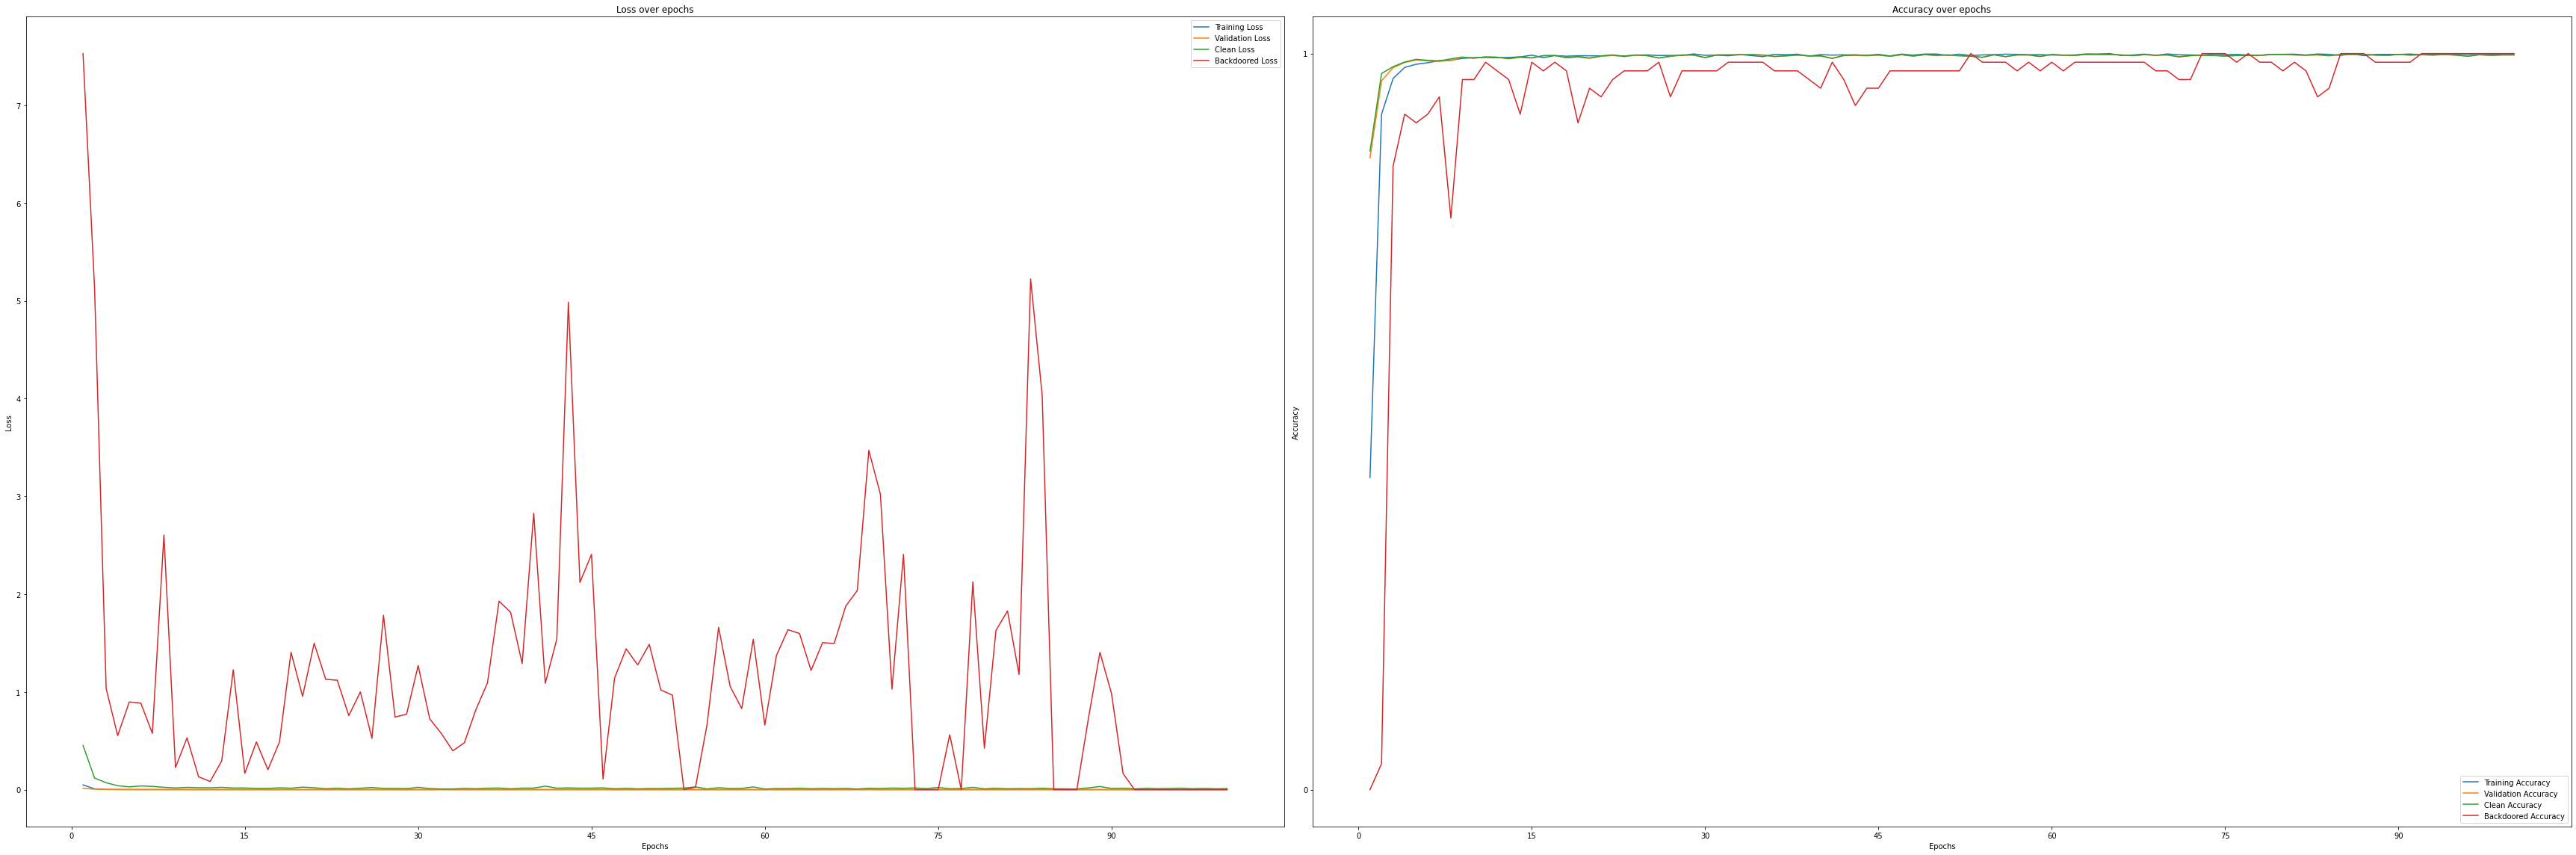

In [27]:
import numpy as np
from matplotlib.ticker import MaxNLocator
# Convert the lists to numpy arrays for indexing
train_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in train_loss])
val_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in val_loss])
clean_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in clean_loss])
back_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in back_loss])
train_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in train_acc])
val_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in val_acc])
clean_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in clean_acc])
back_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in back_acc])
epochs = len(train_loss) 

plt.figure(figsize=(48, 16))

# Plotting Loss
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, 1+epochs), y=train_los, label='Training Loss')
sns.lineplot(x=range(1, 1+epochs), y=val_los, label='Validation Loss')
sns.lineplot(x=range(1, 1+epochs), y=clean_los, label='Clean Loss')
sns.lineplot(x=range(1, 1+epochs), y=back_los, label='Backdoored Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting Accuracy
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, 1+epochs), y=train_ac, label='Training Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=val_ac, label='Validation Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=clean_ac, label='Clean Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=back_ac, label='Backdoored Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

In [5]:
from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
num_epochs = 100
batch_size = 40
out_path = "models/test_alexnet_ran_sqr_sin_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/100
**********


/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


training Loss: 0.0661 || Accuracy: 0.3776
validation Loss: 0.0195 || Accuracy: 0.8127
epoch 2/100
**********
training Loss: 0.0117 || Accuracy: 0.8976
validation Loss: 0.0066 || Accuracy: 0.9562
epoch 3/100
**********
training Loss: 0.0055 || Accuracy: 0.9565
validation Loss: 0.0044 || Accuracy: 0.9698
epoch 4/100
**********
training Loss: 0.0031 || Accuracy: 0.9731
validation Loss: 0.0024 || Accuracy: 0.9780
epoch 5/100
**********
training Loss: 0.0021 || Accuracy: 0.9809
validation Loss: 0.0016 || Accuracy: 0.9865
epoch 6/100
**********
training Loss: 0.0016 || Accuracy: 0.9864
validation Loss: 0.0024 || Accuracy: 0.9833
epoch 7/100
**********
training Loss: 0.0012 || Accuracy: 0.9884
validation Loss: 0.0020 || Accuracy: 0.9864
epoch 8/100
**********
training Loss: 0.0010 || Accuracy: 0.9907
validation Loss: 0.0011 || Accuracy: 0.9908
epoch 9/100
**********
training Loss: 0.0010 || Accuracy: 0.9908
validation Loss: 0.0014 || Accuracy: 0.9911
epoch 10/100
**********
training Loss: 0.0

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

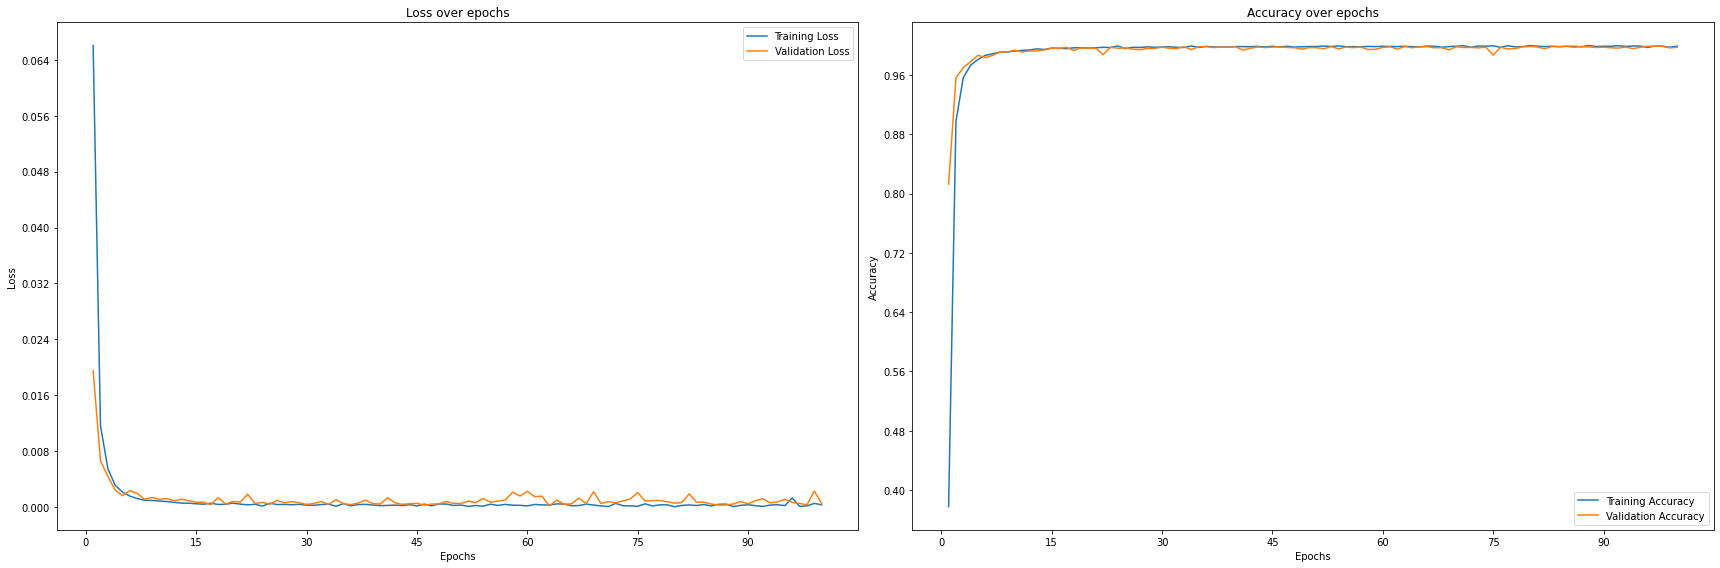

In [8]:

from matplotlib.ticker import MaxNLocator
# # Convert the lists to numpy arrays for indexing
# train_loss = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in train_loss])
# val_loss = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in val_loss])
# train_acc = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in train_acc])
# val_acc = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in val_acc])
epochs = len(train_loss) 

plt.figure(figsize=(24, 8))

# Plotting Loss
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, 1+epochs), y=train_loss, label='Training Loss')
sns.lineplot(x=range(1, 1+epochs), y=val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting Accuracy
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, 1+epochs), y=train_acc, label='Training Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

In [17]:
from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
num_epochs = 100
batch_size = 40
out_path = "models/test_alexnet_ran_sqr_sin_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/100
**********
training Loss: 0.0520 || Accuracy: 0.3788
validation Loss: 0.0220 || Accuracy: 0.7559
clean Loss: 0.7790 || Accuracy: 0.7641
backdoor Loss: 5.0595 || Accuracy: 0.0000
epoch 2/100
**********
training Loss: 0.0105 || Accuracy: 0.8829
validation Loss: 0.0068 || Accuracy: 0.9551
clean Loss: 0.1520 || Accuracy: 0.9650
backdoor Loss: 4.8075 || Accuracy: 0.0353
epoch 3/100
**********
training Loss: 0.0051 || Accuracy: 0.9501
validation Loss: 0.0054 || Accuracy: 0.9635
clean Loss: 0.0946 || Accuracy: 0.9736
backdoor Loss: 5.4077 || Accuracy: 0.0235
epoch 4/100
**********
training Loss: 0.0036 || Accuracy: 0.9640
validation Loss: 0.0048 || Accuracy: 0.9701
clean Loss: 0.0958 || Accuracy: 0.9774
backdoor Loss: 3.0487 || Accuracy: 0.2941
epoch 5/100
**********
training Loss: 0.0023 || Accuracy: 0.9748
validation Loss: 0.0029 || Accuracy: 0.9805
clean Loss: 0.0911 || Accuracy: 0.9809
backdoor Loss: 0.2842 || Accuracy: 0.9412
epoch 6/100
**********
training Loss: 0.0016 || Ac

/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/cc7486/anaconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

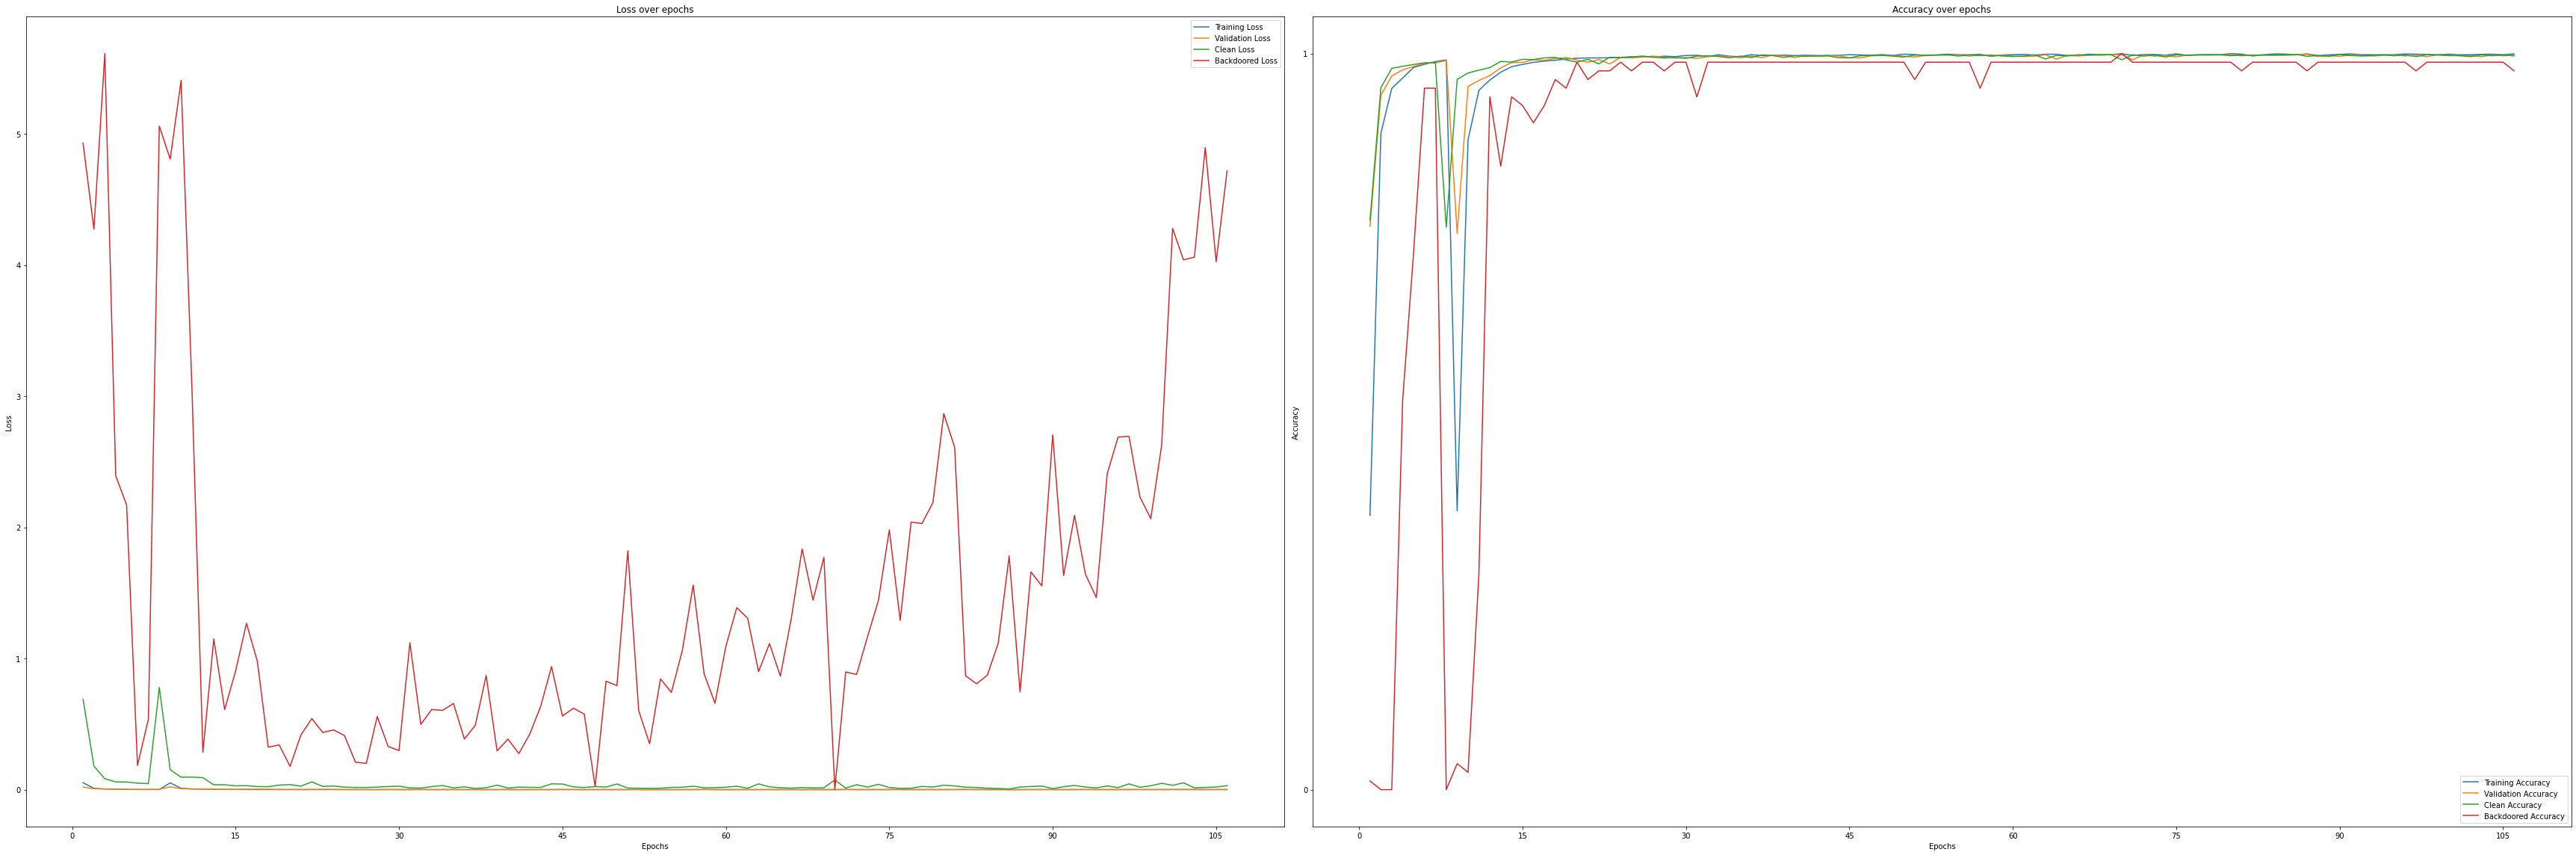

In [23]:
import numpy as np
from matplotlib.ticker import MaxNLocator
# Convert the lists to numpy arrays for indexing
train_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in train_loss])
val_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in val_loss])
clean_los = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in clean_loss])[:-1]
back_los = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in back_loss])[:-1]
train_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in train_acc])
val_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in val_acc])
clean_ac = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in clean_acc])[:-1]
back_ac = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in back_acc])[:-1]
epochs = len(train_loss) 

plt.figure(figsize=(48, 16))

# Plotting Loss
plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, 1+epochs), y=train_los, label='Training Loss')
sns.lineplot(x=range(1, 1+epochs), y=val_los, label='Validation Loss')
sns.lineplot(x=range(1, 1+epochs), y=clean_los, label='Clean Loss')
sns.lineplot(x=range(1, 1+epochs), y=back_los, label='Backdoored Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting Accuracy
plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, 1+epochs), y=train_ac, label='Training Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=val_ac, label='Validation Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=clean_ac, label='Clean Accuracy')
sns.lineplot(x=range(1, 1+epochs), y=back_ac, label='Backdoored Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

Better Training

In [2]:
#ran_sqr_sin_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
num_epochs = 12
batch_size = 40
out_path = "models/alexnet_ran_sqr_sin_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/12
**********


D:\Programs\Anaconda\envs\pytorch\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


training Loss: 0.0630 || Accuracy: 0.4046
validation Loss: 0.0203 || Accuracy: 0.8160
epoch 2/12
**********
training Loss: 0.0119 || Accuracy: 0.8989
validation Loss: 0.0061 || Accuracy: 0.9605
epoch 3/12
**********
training Loss: 0.0054 || Accuracy: 0.9567
validation Loss: 0.0036 || Accuracy: 0.9761
epoch 4/12
**********
training Loss: 0.0027 || Accuracy: 0.9775
validation Loss: 0.0019 || Accuracy: 0.9849
epoch 5/12
**********
training Loss: 0.0019 || Accuracy: 0.9818
validation Loss: 0.0015 || Accuracy: 0.9878
epoch 6/12
**********
training Loss: 0.0014 || Accuracy: 0.9873
validation Loss: 0.0011 || Accuracy: 0.9923
epoch 7/12
**********
training Loss: 0.0011 || Accuracy: 0.9891
validation Loss: 0.0015 || Accuracy: 0.9910
epoch 8/12
**********
training Loss: 0.0010 || Accuracy: 0.9904
validation Loss: 0.0013 || Accuracy: 0.9925
epoch 9/12
**********
training Loss: 0.0008 || Accuracy: 0.9919
validation Loss: 0.0008 || Accuracy: 0.9950
epoch 10/12
**********
training Loss: 0.0010 || Ac

In [4]:
#ran_sqr_mul_01
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
num_epochs = 10
batch_size = 40
out_path = "models/alexnet_ran_sqr_mul_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/10
**********
training Loss: 0.0650 || Accuracy: 0.3883
validation Loss: 0.0236 || Accuracy: 0.7814
epoch 2/10
**********
training Loss: 0.0123 || Accuracy: 0.8858
validation Loss: 0.0056 || Accuracy: 0.9484
epoch 3/10
**********
training Loss: 0.0044 || Accuracy: 0.9589
validation Loss: 0.0030 || Accuracy: 0.9725
epoch 4/10
**********
training Loss: 0.0025 || Accuracy: 0.9776
validation Loss: 0.0019 || Accuracy: 0.9855
epoch 5/10
**********
training Loss: 0.0019 || Accuracy: 0.9827
validation Loss: 0.0009 || Accuracy: 0.9914
epoch 6/10
**********
training Loss: 0.0015 || Accuracy: 0.9871
validation Loss: 0.0017 || Accuracy: 0.9864
epoch 7/10
**********
training Loss: 0.0013 || Accuracy: 0.9878
validation Loss: 0.0010 || Accuracy: 0.9909
epoch 8/10
**********
training Loss: 0.0011 || Accuracy: 0.9900
validation Loss: 0.0015 || Accuracy: 0.9898
epoch 9/10
**********
training Loss: 0.0009 || Accuracy: 0.9914
validation Loss: 0.0010 || Accuracy: 0.9904
epoch 10/10
**********
train

In [6]:
#fixed_sqr_sin_01
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
num_epochs = 10
batch_size = 40
out_path = "models/alexnet_fixed_sqr_sin_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/10
**********
training Loss: 0.0631 || Accuracy: 0.3998
validation Loss: 0.0208 || Accuracy: 0.8119
epoch 2/10
**********
training Loss: 0.0109 || Accuracy: 0.9025
validation Loss: 0.0060 || Accuracy: 0.9539
epoch 3/10
**********
training Loss: 0.0039 || Accuracy: 0.9658
validation Loss: 0.0027 || Accuracy: 0.9768
epoch 4/10
**********
training Loss: 0.0024 || Accuracy: 0.9782
validation Loss: 0.0017 || Accuracy: 0.9838
epoch 5/10
**********
training Loss: 0.0015 || Accuracy: 0.9864
validation Loss: 0.0018 || Accuracy: 0.9853
epoch 6/10
**********
training Loss: 0.0013 || Accuracy: 0.9892
validation Loss: 0.0013 || Accuracy: 0.9924
epoch 7/10
**********
training Loss: 0.0011 || Accuracy: 0.9900
validation Loss: 0.0009 || Accuracy: 0.9931
epoch 8/10
**********
training Loss: 0.0008 || Accuracy: 0.9935
validation Loss: 0.0011 || Accuracy: 0.9911
epoch 9/10
**********
training Loss: 0.0008 || Accuracy: 0.9924
validation Loss: 0.0014 || Accuracy: 0.9883
epoch 10/10
**********
train

In [3]:
#fixed_sqr_mul_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0001)
num_epochs = 12
batch_size = 40
out_path = "models/alexnet_fixed_sqr_mul_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/12
**********


D:\Programs\Anaconda\envs\pytorch\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


training Loss: 0.0648 || Accuracy: 0.3746
validation Loss: 0.0246 || Accuracy: 0.7567
epoch 2/12
**********
training Loss: 0.0116 || Accuracy: 0.8860
validation Loss: 0.0047 || Accuracy: 0.9547
epoch 3/12
**********
training Loss: 0.0037 || Accuracy: 0.9650
validation Loss: 0.0019 || Accuracy: 0.9836
epoch 4/12
**********
training Loss: 0.0022 || Accuracy: 0.9788
validation Loss: 0.0018 || Accuracy: 0.9833
epoch 5/12
**********
training Loss: 0.0014 || Accuracy: 0.9868
validation Loss: 0.0011 || Accuracy: 0.9913
epoch 6/12
**********
training Loss: 0.0011 || Accuracy: 0.9892
validation Loss: 0.0015 || Accuracy: 0.9880
epoch 7/12
**********
training Loss: 0.0013 || Accuracy: 0.9879
validation Loss: 0.0008 || Accuracy: 0.9933
epoch 8/12
**********
training Loss: 0.0009 || Accuracy: 0.9911
validation Loss: 0.0008 || Accuracy: 0.9939
epoch 9/12
**********
training Loss: 0.0008 || Accuracy: 0.9941
validation Loss: 0.0007 || Accuracy: 0.9936
epoch 10/12
**********
training Loss: 0.0007 || Ac

# Training

In [ ]:
# 1

In [6]:
#ran_sqr_sin_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_ran_sqr_sin_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.0831 || Accuracy: 0.2515
validation Loss: 0.0357 || Accuracy: 0.6441
epoch 2/8
**********
training Loss: 0.0272 || Accuracy: 0.7352
validation Loss: 0.0170 || Accuracy: 0.8466
epoch 3/8
**********
training Loss: 0.0169 || Accuracy: 0.8420
validation Loss: 0.0125 || Accuracy: 0.8917
epoch 4/8
**********
training Loss: 0.0141 || Accuracy: 0.8703
validation Loss: 0.0091 || Accuracy: 0.9230
epoch 5/8
**********
training Loss: 0.0122 || Accuracy: 0.8887
validation Loss: 0.0094 || Accuracy: 0.9209
epoch 6/8
**********
training Loss: 0.0112 || Accuracy: 0.8966
validation Loss: 0.0081 || Accuracy: 0.9319
epoch 7/8
**********
training Loss: 0.0100 || Accuracy: 0.9086
validation Loss: 0.0129 || Accuracy: 0.8942
epoch 8/8
**********
training Loss: 0.0098 || Accuracy: 0.9111
validation Loss: 0.0068 || Accuracy: 0.9426
Best validation Accuracy: 0.942647


In [8]:
#ran_sqr_mul_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_ran_sqr_mul_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.0871 || Accuracy: 0.2113
validation Loss: 0.0468 || Accuracy: 0.5133
epoch 2/8
**********
training Loss: 0.0337 || Accuracy: 0.6643
validation Loss: 0.0218 || Accuracy: 0.7927
epoch 3/8
**********
training Loss: 0.0208 || Accuracy: 0.7969
validation Loss: 0.0130 || Accuracy: 0.8765
epoch 4/8
**********
training Loss: 0.0164 || Accuracy: 0.8377
validation Loss: 0.0112 || Accuracy: 0.8938
epoch 5/8
**********
training Loss: 0.0153 || Accuracy: 0.8513
validation Loss: 0.0093 || Accuracy: 0.9107
epoch 6/8
**********
training Loss: 0.0113 || Accuracy: 0.8886
validation Loss: 0.0070 || Accuracy: 0.9349
epoch 7/8
**********
training Loss: 0.0105 || Accuracy: 0.8969
validation Loss: 0.0071 || Accuracy: 0.9363
epoch 8/8
**********
training Loss: 0.0098 || Accuracy: 0.9057
validation Loss: 0.0052 || Accuracy: 0.9531
Best validation Accuracy: 0.953143


In [2]:
#ran_sqr_sin_001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_ran_sqr_sin_001.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********


D:\Programs\Anaconda\envs\pytorch\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


training Loss: 0.0772 || Accuracy: 0.2839
validation Loss: 0.0389 || Accuracy: 0.5915
epoch 2/8
**********
training Loss: 0.0319 || Accuracy: 0.6830
validation Loss: 0.0188 || Accuracy: 0.8209
epoch 3/8
**********
training Loss: 0.0228 || Accuracy: 0.7782
validation Loss: 0.0151 || Accuracy: 0.8558
epoch 4/8
**********
training Loss: 0.0185 || Accuracy: 0.8243
validation Loss: 0.0113 || Accuracy: 0.8952
epoch 5/8
**********
training Loss: 0.0161 || Accuracy: 0.8487
validation Loss: 0.0106 || Accuracy: 0.9073
epoch 6/8
**********
training Loss: 0.0148 || Accuracy: 0.8615
validation Loss: 0.0098 || Accuracy: 0.9069
epoch 7/8
**********
training Loss: 0.0142 || Accuracy: 0.8670
validation Loss: 0.0088 || Accuracy: 0.9283
epoch 8/8
**********
training Loss: 0.0126 || Accuracy: 0.8835
validation Loss: 0.0085 || Accuracy: 0.9233
Best validation Accuracy: 0.928277


In [4]:
#ran_sqr_mul_001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_ran_sqr_mul_001.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.0664 || Accuracy: 0.3719
validation Loss: 0.0269 || Accuracy: 0.7291
epoch 2/8
**********
training Loss: 0.0252 || Accuracy: 0.7542
validation Loss: 0.0146 || Accuracy: 0.8765
epoch 3/8
**********
training Loss: 0.0174 || Accuracy: 0.8378
validation Loss: 0.0117 || Accuracy: 0.8967
epoch 4/8
**********
training Loss: 0.0144 || Accuracy: 0.8714
validation Loss: 0.0102 || Accuracy: 0.9189
epoch 5/8
**********
training Loss: 0.0129 || Accuracy: 0.8839
validation Loss: 0.0090 || Accuracy: 0.9275
epoch 6/8
**********
training Loss: 0.0119 || Accuracy: 0.8963
validation Loss: 0.0080 || Accuracy: 0.9375
epoch 7/8
**********
training Loss: 0.0128 || Accuracy: 0.8895
validation Loss: 0.0072 || Accuracy: 0.9420
epoch 8/8
**********
training Loss: 0.0099 || Accuracy: 0.9137
validation Loss: 0.0081 || Accuracy: 0.9360
Best validation Accuracy: 0.942022


In [4]:
#fixed_sqr_sin_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_fixed_sqr_sin_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.0802 || Accuracy: 0.2749
validation Loss: 0.0313 || Accuracy: 0.6797
epoch 2/8
**********
training Loss: 0.0281 || Accuracy: 0.7183
validation Loss: 0.0151 || Accuracy: 0.8474
epoch 3/8
**********
training Loss: 0.0179 || Accuracy: 0.8248
validation Loss: 0.0101 || Accuracy: 0.9053
epoch 4/8
**********
training Loss: 0.0141 || Accuracy: 0.8646
validation Loss: 0.0082 || Accuracy: 0.9217
epoch 5/8
**********
training Loss: 0.0117 || Accuracy: 0.8853
validation Loss: 0.0065 || Accuracy: 0.9381
epoch 6/8
**********
training Loss: 0.0103 || Accuracy: 0.9002
validation Loss: 0.0060 || Accuracy: 0.9464
epoch 7/8
**********
training Loss: 0.0097 || Accuracy: 0.9063
validation Loss: 0.0060 || Accuracy: 0.9449
epoch 8/8
**********
training Loss: 0.0091 || Accuracy: 0.9124
validation Loss: 0.0051 || Accuracy: 0.9499
Best validation Accuracy: 0.949894


In [2]:
#fixed_sqr_mul_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_fixed_sqr_mul_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********


D:\Programs\Anaconda\envs\pytorch\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


training Loss: 0.0698 || Accuracy: 0.3425
validation Loss: 0.0328 || Accuracy: 0.6516
epoch 2/8
**********
training Loss: 0.0252 || Accuracy: 0.7406
validation Loss: 0.0135 || Accuracy: 0.8678
epoch 3/8
**********
training Loss: 0.0154 || Accuracy: 0.8473
validation Loss: 0.0089 || Accuracy: 0.9119
epoch 4/8
**********
training Loss: 0.0127 || Accuracy: 0.8763
validation Loss: 0.0074 || Accuracy: 0.9300
epoch 5/8
**********
training Loss: 0.0102 || Accuracy: 0.9002
validation Loss: 0.0060 || Accuracy: 0.9429
epoch 6/8
**********
training Loss: 0.0089 || Accuracy: 0.9138
validation Loss: 0.0046 || Accuracy: 0.9588
epoch 7/8
**********
training Loss: 0.0088 || Accuracy: 0.9171
validation Loss: 0.0058 || Accuracy: 0.9443
epoch 8/8
**********
training Loss: 0.0072 || Accuracy: 0.9311
validation Loss: 0.0037 || Accuracy: 0.9643
Best validation Accuracy: 0.964263


In [8]:
#fixed_sqr_sin_001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_fixed_sqr_sin_001.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.0745 || Accuracy: 0.3110
validation Loss: 0.0394 || Accuracy: 0.5999
epoch 2/8
**********
training Loss: 0.0312 || Accuracy: 0.6835
validation Loss: 0.0156 || Accuracy: 0.8499
epoch 3/8
**********
training Loss: 0.0185 || Accuracy: 0.8177
validation Loss: 0.0105 || Accuracy: 0.9018
epoch 4/8
**********
training Loss: 0.0140 || Accuracy: 0.8608
validation Loss: 0.0078 || Accuracy: 0.9267
epoch 5/8
**********
training Loss: 0.0117 || Accuracy: 0.8858
validation Loss: 0.0082 || Accuracy: 0.9232
epoch 6/8
**********
training Loss: 0.0101 || Accuracy: 0.9023
validation Loss: 0.0056 || Accuracy: 0.9469
epoch 7/8
**********
training Loss: 0.0094 || Accuracy: 0.9080
validation Loss: 0.0047 || Accuracy: 0.9574
epoch 8/8
**********
training Loss: 0.0092 || Accuracy: 0.9120
validation Loss: 0.0062 || Accuracy: 0.9406
Best validation Accuracy: 0.957391


In [10]:
#fixed_sqr_mul_001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_fixed_sqr_mul_001.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.0718 || Accuracy: 0.3360
validation Loss: 0.0285 || Accuracy: 0.7165
epoch 2/8
**********
training Loss: 0.0257 || Accuracy: 0.7519
validation Loss: 0.0142 || Accuracy: 0.8740
epoch 3/8
**********
training Loss: 0.0180 || Accuracy: 0.8337
validation Loss: 0.0120 || Accuracy: 0.8967
epoch 4/8
**********
training Loss: 0.0146 || Accuracy: 0.8683
validation Loss: 0.0091 || Accuracy: 0.9287
epoch 5/8
**********
training Loss: 0.0129 || Accuracy: 0.8883
validation Loss: 0.0093 || Accuracy: 0.9280
epoch 6/8
**********
training Loss: 0.0117 || Accuracy: 0.8980
validation Loss: 0.0076 || Accuracy: 0.9374
epoch 7/8
**********
training Loss: 0.0103 || Accuracy: 0.9106
validation Loss: 0.0079 || Accuracy: 0.9364
epoch 8/8
**********
training Loss: 0.0109 || Accuracy: 0.9071
validation Loss: 0.0094 || Accuracy: 0.9242
Best validation Accuracy: 0.937398


In [ ]:
# 2

In [12]:
#ran_cir_sin_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_ran_cir_sin_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.0783 || Accuracy: 0.2735
validation Loss: 0.0417 || Accuracy: 0.5615
epoch 2/8
**********
training Loss: 0.0299 || Accuracy: 0.7017
validation Loss: 0.0141 || Accuracy: 0.8734
epoch 3/8
**********
training Loss: 0.0174 || Accuracy: 0.8355
validation Loss: 0.0097 || Accuracy: 0.9162
epoch 4/8
**********
training Loss: 0.0135 || Accuracy: 0.8762
validation Loss: 0.0105 || Accuracy: 0.9183
epoch 5/8
**********
training Loss: 0.0115 || Accuracy: 0.8948
validation Loss: 0.0078 || Accuracy: 0.9440
epoch 6/8
**********
training Loss: 0.0100 || Accuracy: 0.9112
validation Loss: 0.0071 || Accuracy: 0.9380
epoch 7/8
**********
training Loss: 0.0089 || Accuracy: 0.9170
validation Loss: 0.0062 || Accuracy: 0.9506
epoch 8/8
**********
training Loss: 0.0084 || Accuracy: 0.9229
validation Loss: 0.0055 || Accuracy: 0.9569
Best validation Accuracy: 0.956891


In [18]:
#ran_cir_mul_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_ran_cir_mul_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.0703 || Accuracy: 0.3363
validation Loss: 0.0355 || Accuracy: 0.6385
epoch 2/8
**********
training Loss: 0.0266 || Accuracy: 0.7377
validation Loss: 0.0183 || Accuracy: 0.8226
epoch 3/8
**********
training Loss: 0.0169 || Accuracy: 0.8400
validation Loss: 0.0114 || Accuracy: 0.9010
epoch 4/8
**********
training Loss: 0.0126 || Accuracy: 0.8817
validation Loss: 0.0087 || Accuracy: 0.9220
epoch 5/8
**********
training Loss: 0.0108 || Accuracy: 0.8989
validation Loss: 0.0079 || Accuracy: 0.9324
epoch 6/8
**********
training Loss: 0.0088 || Accuracy: 0.9172
validation Loss: 0.0078 || Accuracy: 0.9227
epoch 7/8
**********
training Loss: 0.0083 || Accuracy: 0.9226
validation Loss: 0.0070 || Accuracy: 0.9404
epoch 8/8
**********
training Loss: 0.0076 || Accuracy: 0.9289
validation Loss: 0.0055 || Accuracy: 0.9479
Best validation Accuracy: 0.947895


In [20]:
#ran_cir_sin_001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_ran_cir_sin_001.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.0683 || Accuracy: 0.3684
validation Loss: 0.0257 || Accuracy: 0.7463
epoch 2/8
**********
training Loss: 0.0211 || Accuracy: 0.8071
validation Loss: 0.0121 || Accuracy: 0.9015
epoch 3/8
**********
training Loss: 0.0142 || Accuracy: 0.8785
validation Loss: 0.0099 || Accuracy: 0.9219
epoch 4/8
**********
training Loss: 0.0119 || Accuracy: 0.8985
validation Loss: 0.0087 || Accuracy: 0.9239
epoch 5/8
**********
training Loss: 0.0106 || Accuracy: 0.9094
validation Loss: 0.0076 || Accuracy: 0.9399
epoch 6/8
**********
training Loss: 0.0095 || Accuracy: 0.9194
validation Loss: 0.0073 || Accuracy: 0.9410
epoch 7/8
**********
training Loss: 0.0099 || Accuracy: 0.9181
validation Loss: 0.0062 || Accuracy: 0.9524
epoch 8/8
**********
training Loss: 0.0081 || Accuracy: 0.9316
validation Loss: 0.0066 || Accuracy: 0.9523
Best validation Accuracy: 0.952393


In [4]:
#ran_cir_mul_001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_ran_cir_mul_001.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.0793 || Accuracy: 0.2880
validation Loss: 0.0292 || Accuracy: 0.7097
epoch 2/8
**********
training Loss: 0.0226 || Accuracy: 0.7908
validation Loss: 0.0179 || Accuracy: 0.8494
epoch 3/8
**********
training Loss: 0.0151 || Accuracy: 0.8668
validation Loss: 0.0091 || Accuracy: 0.9315
epoch 4/8
**********
training Loss: 0.0125 || Accuracy: 0.8902
validation Loss: 0.0074 || Accuracy: 0.9503
epoch 5/8
**********
training Loss: 0.0113 || Accuracy: 0.9033
validation Loss: 0.0082 || Accuracy: 0.9366
epoch 6/8
**********
training Loss: 0.0102 || Accuracy: 0.9121
validation Loss: 0.0080 || Accuracy: 0.9400
epoch 7/8
**********
training Loss: 0.0100 || Accuracy: 0.9137
validation Loss: 0.0079 || Accuracy: 0.9379
epoch 8/8
**********
training Loss: 0.0090 || Accuracy: 0.9237
validation Loss: 0.0069 || Accuracy: 0.9499
Best validation Accuracy: 0.950269


In [9]:
#fixed_cir_sin_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_fixed_cir_sin_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.0691 || Accuracy: 0.3510
validation Loss: 0.0280 || Accuracy: 0.7256
epoch 2/8
**********
training Loss: 0.0232 || Accuracy: 0.7755
validation Loss: 0.0109 || Accuracy: 0.9025
epoch 3/8
**********
training Loss: 0.0137 || Accuracy: 0.8711
validation Loss: 0.0075 || Accuracy: 0.9339
epoch 4/8
**********
training Loss: 0.0111 || Accuracy: 0.8961
validation Loss: 0.0072 || Accuracy: 0.9356
epoch 5/8
**********
training Loss: 0.0111 || Accuracy: 0.8999
validation Loss: 0.0063 || Accuracy: 0.9453
epoch 6/8
**********
training Loss: 0.0084 || Accuracy: 0.9248
validation Loss: 0.0062 || Accuracy: 0.9506
epoch 7/8
**********
training Loss: 0.0076 || Accuracy: 0.9318
validation Loss: 0.0051 || Accuracy: 0.9550
epoch 8/8
**********
training Loss: 0.0075 || Accuracy: 0.9309
validation Loss: 0.0052 || Accuracy: 0.9618
Best validation Accuracy: 0.961764


In [13]:
#fixed_cir_mul_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_fixed_cir_mul_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.0872 || Accuracy: 0.2075
validation Loss: 0.0478 || Accuracy: 0.4924
epoch 2/8
**********
training Loss: 0.0372 || Accuracy: 0.6196
validation Loss: 0.0205 || Accuracy: 0.8016
epoch 3/8
**********
training Loss: 0.0206 || Accuracy: 0.7890
validation Loss: 0.0123 || Accuracy: 0.8763
epoch 4/8
**********
training Loss: 0.0158 || Accuracy: 0.8376
validation Loss: 0.0107 || Accuracy: 0.8917
epoch 5/8
**********
training Loss: 0.0132 || Accuracy: 0.8650
validation Loss: 0.0092 || Accuracy: 0.9110
epoch 6/8
**********
training Loss: 0.0118 || Accuracy: 0.8792
validation Loss: 0.0076 || Accuracy: 0.9265
epoch 7/8
**********
training Loss: 0.0107 || Accuracy: 0.8917
validation Loss: 0.0082 || Accuracy: 0.9218
epoch 8/8
**********
training Loss: 0.0103 || Accuracy: 0.8968
validation Loss: 0.0177 || Accuracy: 0.8528
Best validation Accuracy: 0.926528


In [9]:
#fixed_cir_sin_001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_fixed_cir_sin_001.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.0788 || Accuracy: 0.2548
validation Loss: 0.0550 || Accuracy: 0.4480
epoch 2/8
**********
training Loss: 0.0328 || Accuracy: 0.6722
validation Loss: 0.0156 || Accuracy: 0.8564
epoch 3/8
**********
training Loss: 0.0169 || Accuracy: 0.8461
validation Loss: 0.0105 || Accuracy: 0.9153
epoch 4/8
**********
training Loss: 0.0130 || Accuracy: 0.8848
validation Loss: 0.0091 || Accuracy: 0.9268
epoch 5/8
**********
training Loss: 0.0114 || Accuracy: 0.9002
validation Loss: 0.0083 || Accuracy: 0.9350
epoch 6/8
**********
training Loss: 0.0104 || Accuracy: 0.9107
validation Loss: 0.0076 || Accuracy: 0.9443
epoch 7/8
**********
training Loss: 0.0097 || Accuracy: 0.9150
validation Loss: 0.0068 || Accuracy: 0.9469
epoch 8/8
**********
training Loss: 0.0089 || Accuracy: 0.9228
validation Loss: 0.0066 || Accuracy: 0.9484
Best validation Accuracy: 0.948394


In [ ]:
#fixed_cir_mul_001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_fixed_cir_mul_001.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.1098 || Accuracy: 0.0529
validation Loss: 0.1099 || Accuracy: 0.0594
epoch 2/8
**********


In [ ]:
# 3

In [6]:
#ran_tri_sin_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_ran_tri_sin_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.0729 || Accuracy: 0.2977
validation Loss: 0.0427 || Accuracy: 0.5323
epoch 2/8
**********
training Loss: 0.0340 || Accuracy: 0.6596
validation Loss: 0.0164 || Accuracy: 0.8418
epoch 3/8
**********
training Loss: 0.0171 || Accuracy: 0.8427
validation Loss: 0.0090 || Accuracy: 0.9218
epoch 4/8
**********
training Loss: 0.0119 || Accuracy: 0.8936
validation Loss: 0.0067 || Accuracy: 0.9449
epoch 5/8
**********
training Loss: 0.0100 || Accuracy: 0.9115
validation Loss: 0.0066 || Accuracy: 0.9416
epoch 6/8
**********
training Loss: 0.0094 || Accuracy: 0.9179
validation Loss: 0.0048 || Accuracy: 0.9621
epoch 7/8
**********
training Loss: 0.0081 || Accuracy: 0.9299
validation Loss: 0.0052 || Accuracy: 0.9555
epoch 8/8
**********
training Loss: 0.0075 || Accuracy: 0.9332
validation Loss: 0.0066 || Accuracy: 0.9404
Best validation Accuracy: 0.962139


In [8]:
#ran_tri_mul_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_ran_tri_mul_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.0662 || Accuracy: 0.4007
validation Loss: 0.0192 || Accuracy: 0.8199
epoch 2/8
**********
training Loss: 0.0178 || Accuracy: 0.8392
validation Loss: 0.0104 || Accuracy: 0.9142
epoch 3/8
**********
training Loss: 0.0125 || Accuracy: 0.8901
validation Loss: 0.0085 || Accuracy: 0.9320
epoch 4/8
**********
training Loss: 0.0103 || Accuracy: 0.9096
validation Loss: 0.0087 || Accuracy: 0.9312
epoch 5/8
**********
training Loss: 0.0094 || Accuracy: 0.9205
validation Loss: 0.0069 || Accuracy: 0.9433
epoch 6/8
**********
training Loss: 0.0080 || Accuracy: 0.9285
validation Loss: 0.0058 || Accuracy: 0.9476
epoch 7/8
**********
training Loss: 0.0077 || Accuracy: 0.9296
validation Loss: 0.0069 || Accuracy: 0.9396
epoch 8/8
**********
training Loss: 0.0069 || Accuracy: 0.9360
validation Loss: 0.0042 || Accuracy: 0.9603
Best validation Accuracy: 0.960265


In [11]:
#ran_tri_sin_001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_ran_tri_sin_001.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.0697 || Accuracy: 0.3385
validation Loss: 0.0330 || Accuracy: 0.6619
epoch 2/8
**********
training Loss: 0.0265 || Accuracy: 0.7452
validation Loss: 0.0141 || Accuracy: 0.8754
epoch 3/8
**********
training Loss: 0.0168 || Accuracy: 0.8479
validation Loss: 0.0115 || Accuracy: 0.9062
epoch 4/8
**********
training Loss: 0.0133 || Accuracy: 0.8857
validation Loss: 0.0096 || Accuracy: 0.9213
epoch 5/8
**********
training Loss: 0.0120 || Accuracy: 0.8994
validation Loss: 0.0081 || Accuracy: 0.9332
epoch 6/8
**********
training Loss: 0.0107 || Accuracy: 0.9081
validation Loss: 0.0080 || Accuracy: 0.9378
epoch 7/8
**********
training Loss: 0.0101 || Accuracy: 0.9148
validation Loss: 0.0073 || Accuracy: 0.9463
epoch 8/8
**********
training Loss: 0.0103 || Accuracy: 0.9121
validation Loss: 0.0068 || Accuracy: 0.9493
Best validation Accuracy: 0.949269


In [2]:
#ran_tri_mul_001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_ran_tri_mul_001.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********


D:\Programs\Anaconda\envs\pytorch\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


training Loss: 0.0760 || Accuracy: 0.2867
validation Loss: 0.0432 || Accuracy: 0.5635
epoch 2/8
**********
training Loss: 0.0333 || Accuracy: 0.6671
validation Loss: 0.0175 || Accuracy: 0.8453
epoch 3/8
**********
training Loss: 0.0211 || Accuracy: 0.7997
validation Loss: 0.0126 || Accuracy: 0.8880
epoch 4/8
**********
training Loss: 0.0167 || Accuracy: 0.8429
validation Loss: 0.0114 || Accuracy: 0.8982
epoch 5/8
**********
training Loss: 0.0147 || Accuracy: 0.8659
validation Loss: 0.0103 || Accuracy: 0.9099
epoch 6/8
**********
training Loss: 0.0133 || Accuracy: 0.8782
validation Loss: 0.0080 || Accuracy: 0.9370
epoch 7/8
**********
training Loss: 0.0119 || Accuracy: 0.8891
validation Loss: 0.0084 || Accuracy: 0.9319
epoch 8/8
**********
training Loss: 0.0118 || Accuracy: 0.8939
validation Loss: 0.0077 || Accuracy: 0.9356
Best validation Accuracy: 0.937024


In [6]:
#fixed_tri_sin_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_fixed_tri_sin_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.0749 || Accuracy: 0.3029
validation Loss: 0.0353 || Accuracy: 0.6309
epoch 2/8
**********
training Loss: 0.0290 || Accuracy: 0.6928
validation Loss: 0.0174 || Accuracy: 0.8219
epoch 3/8
**********
training Loss: 0.0196 || Accuracy: 0.7997
validation Loss: 0.0126 || Accuracy: 0.8709
epoch 4/8
**********
training Loss: 0.0156 || Accuracy: 0.8427
validation Loss: 0.0107 || Accuracy: 0.8914
epoch 5/8
**********
training Loss: 0.0130 || Accuracy: 0.8663
validation Loss: 0.0091 || Accuracy: 0.9077
epoch 6/8
**********
training Loss: 0.0119 || Accuracy: 0.8821
validation Loss: 0.0075 || Accuracy: 0.9307
epoch 7/8
**********
training Loss: 0.0105 || Accuracy: 0.8957
validation Loss: 0.0088 || Accuracy: 0.9169
epoch 8/8
**********
training Loss: 0.0101 || Accuracy: 0.9011
validation Loss: 0.0134 || Accuracy: 0.8669
Best validation Accuracy: 0.930651


In [11]:
#fixed_tri_mul_01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_fixed_tri_mul_01.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.0678 || Accuracy: 0.3319
validation Loss: 0.0481 || Accuracy: 0.5018
epoch 2/8
**********
training Loss: 0.0374 || Accuracy: 0.6194
validation Loss: 0.0229 || Accuracy: 0.7820
epoch 3/8
**********
training Loss: 0.0235 || Accuracy: 0.7652
validation Loss: 0.0157 || Accuracy: 0.8506
epoch 4/8
**********
training Loss: 0.0171 || Accuracy: 0.8290
validation Loss: 0.0121 || Accuracy: 0.8750
epoch 5/8
**********
training Loss: 0.0138 || Accuracy: 0.8638
validation Loss: 0.0099 || Accuracy: 0.9024
epoch 6/8
**********
training Loss: 0.0128 || Accuracy: 0.8778
validation Loss: 0.0097 || Accuracy: 0.9083
epoch 7/8
**********
training Loss: 0.0108 || Accuracy: 0.8961
validation Loss: 0.0073 || Accuracy: 0.9335
epoch 8/8
**********
training Loss: 0.0100 || Accuracy: 0.9039
validation Loss: 0.0069 || Accuracy: 0.9373
Best validation Accuracy: 0.937274


In [16]:
#fixed_tri_sin_001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_fixed_tri_sin_001.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.1041 || Accuracy: 0.1030
validation Loss: 0.0850 || Accuracy: 0.2172
epoch 2/8
**********
training Loss: 0.0500 || Accuracy: 0.4830
validation Loss: 0.0312 || Accuracy: 0.6877
epoch 3/8
**********
training Loss: 0.0250 || Accuracy: 0.7540
validation Loss: 0.0149 || Accuracy: 0.8738
epoch 4/8
**********
training Loss: 0.0164 || Accuracy: 0.8469
validation Loss: 0.0120 || Accuracy: 0.8984
epoch 5/8
**********
training Loss: 0.0131 || Accuracy: 0.8816
validation Loss: 0.0107 || Accuracy: 0.9119
epoch 6/8
**********
training Loss: 0.0120 || Accuracy: 0.8936
validation Loss: 0.0100 || Accuracy: 0.9195
epoch 7/8
**********
training Loss: 0.0108 || Accuracy: 0.9038
validation Loss: 0.0098 || Accuracy: 0.9202
epoch 8/8
**********
training Loss: 0.0102 || Accuracy: 0.9100
validation Loss: 0.0081 || Accuracy: 0.9419
Best validation Accuracy: 0.941897


In [19]:
#fixed_tri_mul_001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torchvision.models import alexnet
model = alexnet(weights=None, num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
num_epochs = 8
batch_size = 32
out_path = "models/alexnet_fixed_tri_mul_001.pt"

#train the model
Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path)

epoch 1/8
**********
training Loss: 0.0885 || Accuracy: 0.2045
validation Loss: 0.0439 || Accuracy: 0.5555
epoch 2/8
**********
training Loss: 0.0292 || Accuracy: 0.7081
validation Loss: 0.0152 || Accuracy: 0.8628
epoch 3/8
**********
training Loss: 0.0177 || Accuracy: 0.8351
validation Loss: 0.0108 || Accuracy: 0.9083
epoch 4/8
**********
training Loss: 0.0142 || Accuracy: 0.8723
validation Loss: 0.0111 || Accuracy: 0.9030
epoch 5/8
**********
training Loss: 0.0124 || Accuracy: 0.8925
validation Loss: 0.0088 || Accuracy: 0.9260
epoch 6/8
**********
training Loss: 0.0108 || Accuracy: 0.9063
validation Loss: 0.0069 || Accuracy: 0.9511
epoch 7/8
**********
training Loss: 0.0101 || Accuracy: 0.9133
validation Loss: 0.0072 || Accuracy: 0.9510
epoch 8/8
**********
training Loss: 0.0098 || Accuracy: 0.9157
validation Loss: 0.0068 || Accuracy: 0.9518
Best validation Accuracy: 0.951768


In [17]:
import numpy as np 
import pandas as pd 
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import seaborn as sns
import matplotlib.pyplot as plt
import random
import seaborn as sns
from collections import Counter

from PIL import Image
from skimage import io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim

import torchvision.datasets
import torchvision.transforms as T 
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader
# Transforming the Data ToTensor and Normalize it 
transforms = T.Compose([T.ToTensor(),T.Resize((225,225)),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

class TSignsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.class_counts = Counter()  # Counter to store class counts
        
        # Iterate over each folder (class) in the directory
        for class_id in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_id)
            
            # Make sure it's a directory
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        self.data.append({
                            'path': os.path.join(class_dir, filename),
                            'class_id': int(class_id)
                        })
                        # Increment the count for the current class_id
                        self.class_counts[int(class_id)] += 1
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path = self.data[index]['path']
        image = Image.open(image_path)
        y_class = torch.tensor(self.data[index]['class_id'])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_class)

dataset_path = 'D:/IchMorningstar/Research/MLLsecurity/gtsrb-german-traffic-sign/Train'
dataset_set = TSignsDataset(dataset_path,transform=transforms)

#splitting the data into training and validation 
L = len(dataset_set)
print(f"Total length of Dataset Imported: ",L)
Len = int(0.8*L)
train_set, val_set = random_split(dataset_set,[Len,int(L-Len)])

#Loading the data into DataLoader

train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=val_set, batch_size=32, shuffle=False)

dataloaders = {'training':train_loader,'validation':valid_loader}
dataset_sizes = {'training':len(train_loader.dataset),'validation':len(valid_loader.dataset)}
print(dataset_sizes)

# Store metrics
train_loss, val_loss = [], []
train_acc, val_acc = [], []
    
def Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path):
        best_model_weights = model.state_dict()
        best_acc = 0.0
    
        for epoch in range(num_epochs):
            print("epoch {}/{}".format(epoch+1,num_epochs))
            print("*" * 10)

            for x in ["training","validation"]:
                if x == "training" :
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_accuracy = 0

                for data in dataloaders[x]:
                    img , y = data
                    img , y = img.to(device) , y.to(device)

                    optimizer.zero_grad()
                    y_pred = model(img)
                    loss = criterion(y_pred,y)
                    _, preds = torch.max(y_pred, dim=1)

                    if x == 'training':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item()
                    running_accuracy += torch.sum(preds == y.data)


                epoch_loss = running_loss / dataset_sizes[x]
                epoch_acc = running_accuracy / dataset_sizes[x]

                print('{} Loss: {:.4f} || Accuracy: {:.4f}'.format(x, epoch_loss, epoch_acc))

                # Save metrics
                if x == 'training':
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_acc)
                else:
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_acc)

                # deep copy the model
                if x == 'validation' and epoch_acc > best_acc:
                    best_acc = epoch_acc


        # load best model weights
        torch.save(model.state_dict(), out_path)
        return print('Best validation Accuracy: {:4f}'.format(best_acc))

Total length of Dataset Imported:  40012
{'training': 32009, 'validation': 8003}
